# Index   <a class="anchor" id="index"></a>
* [Index](#index)
* [Data Preparation](#first-bullet)
* [Gibbs Sampler](#second-bullet)
* [Unbiased Weak Prior](#third-bullet)
* [Unbiased Uninformative Prior](#fourth-bullet)
* [Unbiased Informative Prior](#fifth-bullet)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from scipy.stats import invwishart
from scipy.stats import invgamma
from sklearn.linear_model import LinearRegression

# Data Preparation  <a class="anchor" id="first-bullet"></a>
[Index](#index) <a class="anchor" id="index"></a>

In [2]:
data = pd.read_csv("Scores_with_covariates", sep=" ")
data

,sch_id,sch_freelunch,stu_ses,stu_mathscore
0,1011,6,-0.059948,52.11
1,1011,6,1.051652,57.65
2,1011,6,-0.863515,66.44
3,1011,6,-0.796551,44.68
4,1011,6,-1.613511,40.57
...,...,...,...,...
1988,3702,8,0.234693,54.95
1989,3702,8,-0.823337,30.29
1990,3702,8,0.890939,47.66
1991,3702,8,-0.421553,55.43


In [3]:
def plot_trace(b, ax, lag_sum=250):
    if not isinstance(b, np.ndarray):
        b = np.array(b)
    
    b_avg = np.zeros(len(b))
    for i in range(len(b)):
        b_avg[i] = np.mean(b[max(0, i-lag_sum): i+1])
    ax.plot(b, label='Samples from the Markov Chain')
    ax.plot(b_avg, label=f'Moving Average: last {lag_sum} values')
    #ax.set_title('Markov Chain')
    ax.legend(loc=3)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Values")

In [4]:
sch_list = list(data["sch_id"].unique())
sch_list = np.array(sch_list)
index = [i for i in range(100)]
index = np.array(index)
sch_ind = np.stack((sch_list, index), axis = 1)
dff = pd.DataFrame(sch_ind, columns = ['sch_id','sch_index'])
df = pd.merge(data, dff, how='inner', on='sch_id')

In [5]:
df['intercept'] = 1

# Gibbs Sampler  <a class="anchor" id="second-bullet"></a>
[Index](#index) <a class="anchor" id="index"></a>

In [6]:
def posterior_independent_ses(data, mu0, tri_0, eta0, S0, V0, sigma2_0, burnin, iterafter_burnin):
    df = data
    X = df[['sch_index','intercept', 'stu_ses']]
    Y = df[['sch_index', 'stu_mathscore']]
    n = np.shape(X)[0]
    p = 2
    m = X["sch_index"].nunique() #100
    
    y_list = []
    for j in range(100):
        Y_j = Y[Y['sch_index']==j]['stu_mathscore'].to_numpy()
        y_list.append(Y_j)
    X_list = []
    for j in range(100):
        X_j = df[df['sch_index'] == j][['intercept', 'stu_ses']].to_numpy()
        X_list.append(X_j)
        

    
    #initial values
    Sigma = np.eye(2) #check this
    Beta = np.random.multivariate_normal(mean = np.zeros((2,)), cov = Sigma, size = m)
    #theta = X.groupby("sch_index").agg("mean")[["intercept","sch_freelunch","stu_ses"]].to_numpy()
    theta = np.zeros((2,))
    sigsq = Y['stu_mathscore'].var()
    
    sigsq_samp2 = np.zeros((iterafter_burnin))
    Sigma_samp2 = np.zeros((iterafter_burnin, p,p))
    Beta_samp2 = np.zeros((iterafter_burnin, m,p))
    Theta_samp2 = np.zeros((iterafter_burnin, p))
    
    
    for i in range(burnin):
        #Beta
        for j in range(m):
            bvar = np.linalg.inv(np.linalg.inv(Sigma)+(X_list[j].T@X_list[j])/int(sigsq))
            bmean = bvar@(np.linalg.inv(Sigma)@theta+(X_list[j].T@y_list[j])/int(sigsq)) 
            Beta[j] = np.random.multivariate_normal(mean = bmean, cov = bvar)
        
        #Theta
        tvar = np.linalg.inv(np.linalg.inv(tri_0)+m*np.linalg.inv(Sigma))
        tmean = tvar@(np.linalg.inv(tri_0)@mu0+m*np.linalg.inv(Sigma)@np.mean(Beta, axis = 0))
        theta = np.random.multivariate_normal(mean = tmean, cov = tvar)
        
        #Sigma
        stheta = 0
        for j in range(m):
            stheta = stheta + np.array([(Beta[j]-theta)]).T @np.array([(Beta[j]-theta)])
        Sigma = invwishart.rvs(df = eta0+m, scale = S0 + stheta)
        
        
        #sigma_square
        a = (V0 + n) / 2
        SSR = 0
        for j in range(m):
            SSR += np.sum((y_list[j] - (Beta[j]@X_list[j].T))**2)
        b = ((V0*sigma2_0+ SSR) / 2)
        sigsq_inv = np.random.gamma(shape = a, scale = 1/b)
        sigsq = 1/sigsq_inv
    
    for i in range(iterafter_burnin):
        #Beta
        for j in range(m):
            bvar = np.linalg.inv(np.linalg.inv(Sigma)+(X_list[j].T@X_list[j])/int(sigsq))
            bmean = bvar@(np.linalg.inv(Sigma)@theta+(X_list[j].T@y_list[j])/int(sigsq)) 
            Beta[j] = np.random.multivariate_normal(mean = bmean, cov = bvar)
        
        #Theta
        tvar = np.linalg.inv(np.linalg.inv(tri_0)+m*np.linalg.inv(Sigma))
        tmean = tvar@(np.linalg.inv(tri_0)@mu0+m*np.linalg.inv(Sigma)@np.mean(Beta, axis = 0))
        theta = np.random.multivariate_normal(mean = tmean, cov = tvar)
        
        #Sigma
        stheta = 0
        for j in range(m):
            stheta = stheta + np.array([(Beta[j]-theta)]).T @ np.array([(Beta[j]-theta)])
        Sigma = invwishart.rvs(df = eta0+m, scale = (S0 + stheta))
        
        #sigma_square
        a = (V0 + n) / 2
        SSR = 0
        for j in range(m):
            SSR += np.sum((y_list[j] - (Beta[j]@X_list[j].T))**2)
        b = ((V0*sigma2_0+ SSR) / 2)
        sigsq_inv = np.random.gamma(shape = a, scale = 1/b)
        sigsq = 1/sigsq_inv
        
    
        
        sigsq_samp2[i] = sigsq
        Sigma_samp2[i] = Sigma
        Beta_samp2[i] = Beta
        Theta_samp2[i] = theta
    
    return Theta_samp2, Sigma_samp2, Beta_samp2, sigsq_samp2

In [7]:
X = df[['sch_index','stu_ses']]
Y = df[['sch_index', 'stu_mathscore']]
y_list = []
for j in range(100):
    Y_j = Y[Y['sch_index']==j]['stu_mathscore'].to_numpy()
    y_list.append(Y_j)
X_list = []
for j in range(100):
    X_j = df[df['sch_index'] == j]['stu_ses'].to_numpy()
    X_list.append(X_j)

In [8]:
mu0 = []
sigma = []


for i in range(100):
    X_ols = X_list[i]
    y_ols = y_list[i]
    
    
    reg = LinearRegression().fit(X_ols.reshape(-1,1), y_ols)
    mu0.append([reg.intercept_, reg.coef_[0]])
    
    #ols = sm.OLS(Y_ols, X_ols)
    #ols_result = ols.fit()
    #ols_result.cov_HC0
average_theta = np.mean(mu0, axis=0)
average_theta_cov = np.cov(np.array(mu0).T)
within_group_sample_variance = 0
for j in range(100):
    within_group_sample_variance += y_list[j].var()
avg_within_group_sample_variance = within_group_sample_variance / 100




In [9]:
S0 = 0
for j in range(100):
    S0 = S0 + np.array([(mu0[j]-average_theta)]).T @ np.array([(mu0[j]-average_theta)])
S0

array([[2752.78287866,  132.19158493],
       [ 132.19158493,  999.85657282]])

# Unbiased Weak Prior <a class="anchor" id="third-bullet"></a>
[Index](#index) <a class="anchor" id="index"></a>

In [45]:
average_theta

array([47.76577443,  2.37353331])

In [12]:
#sigma2 prior parameters: inverse-gamma
V0 = 1
sigma2_0 = avg_within_group_sample_variance
#cov prior paramaters: inverse-Wishart
eta0 = 4
S0 = S0
#theta prior parameters: multivariate normal
mu0 = average_theta
tri_0 = average_theta_cov

Theta, Cov, Beta, Sigma2 = posterior_independent_ses(data=df, mu0 = mu0, tri_0 = tri_0, eta0 = eta0, S0 = S0, V0 = V0, sigma2_0 = sigma2_0, burnin = 5000, iterafter_burnin = 10000)

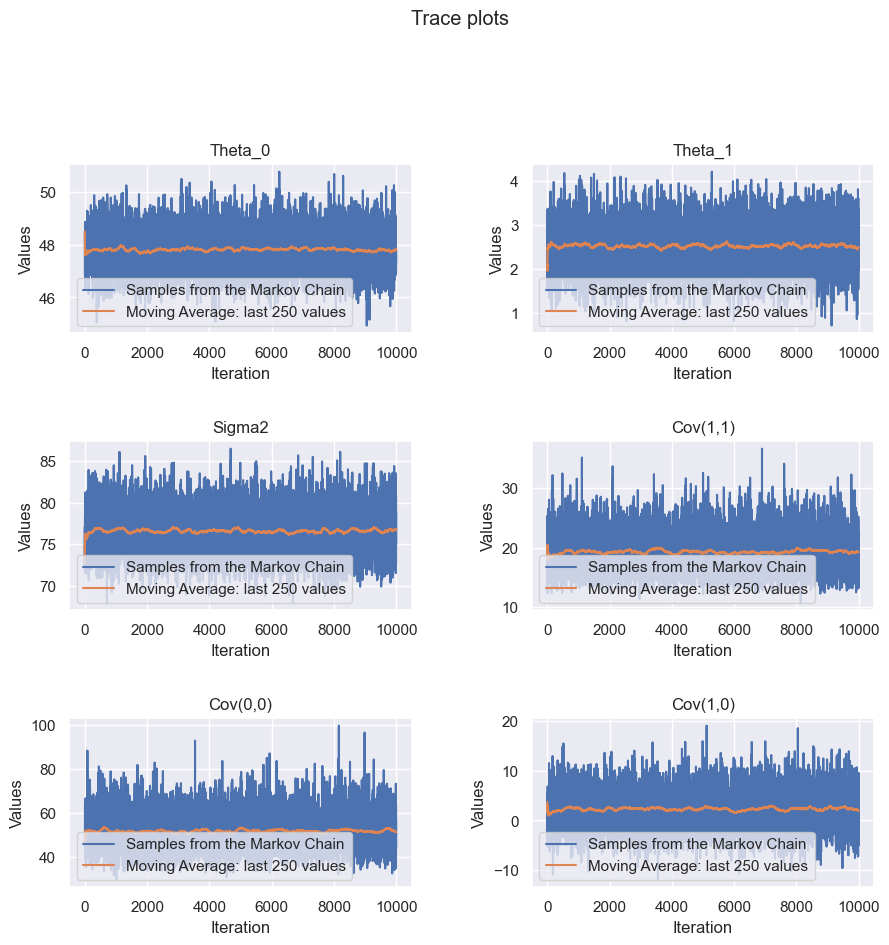

In [13]:
sns.set(style="darkgrid")

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (10,10))
fig.suptitle("Trace plots")
fig.tight_layout(pad=4.5)


ax1.set_title("Theta_0")
#ax1.plot(np.arange(5000), Theta_0_10th[:,0])
plot_trace(Theta[:,0], ax = ax1)
ax2.set_title("Theta_1")
#ax2.plot(np.arange(5000), Theta_0_10th[:,1])
plot_trace(Theta[:,1], ax = ax2)
ax3.set_title("Sigma2")
#ax3.plot(np.arange(5000), Sigma2_0_10th)
plot_trace(Sigma2, ax = ax3)
ax4.set_title("Cov(1,1)")
#ax4.plot(np.arange(5000), Cov_0_10th[:,1,1])
plot_trace(Cov[:,1,1], ax = ax4)
ax5.set_title("Cov(0,0)")
#ax5.plot(np.arange(5000), Cov_0_10th[:,0,0])
plot_trace(Cov[:,0,0], ax = ax5)
ax6.set_title("Cov(1,0)")
#ax6.plot(np.arange(5000), Cov_0_10th[:,1,0])
plot_trace(Cov[:,1,0], ax = ax6)

plt.savefig("Unbiased Weak Prior Traceplots.png")
plt.show()

In [14]:
def plot_trace1(b, lag_sum=50):
    if not isinstance(b, np.ndarray):
        b = np.array(b)
    
    b_avg = np.zeros(len(b))
    for i in range(len(b)):
        b_avg[i] = np.mean(b[max(0, i-lag_sum): i+1])

    plt.plot(b, label='Resulting MC')
    plt.plot(b_avg, label=f'Moving average of the last {lag_sum} values')
    plt.title('Resulting MC')
    plt.legend(loc=3)
    plt.xlabel("Iteration")
    plt.ylabel("Values")

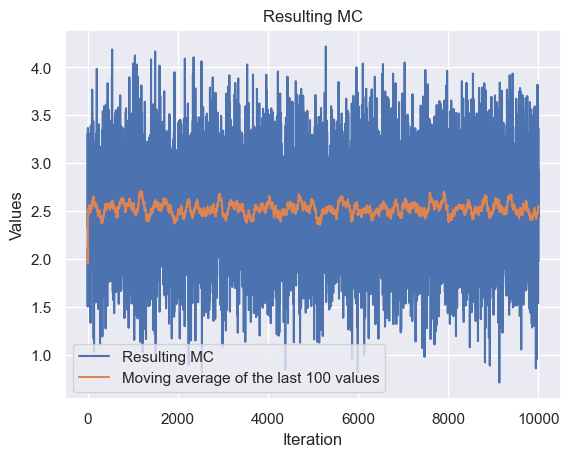

In [15]:
plot_trace1(Theta[:,1], lag_sum=100)

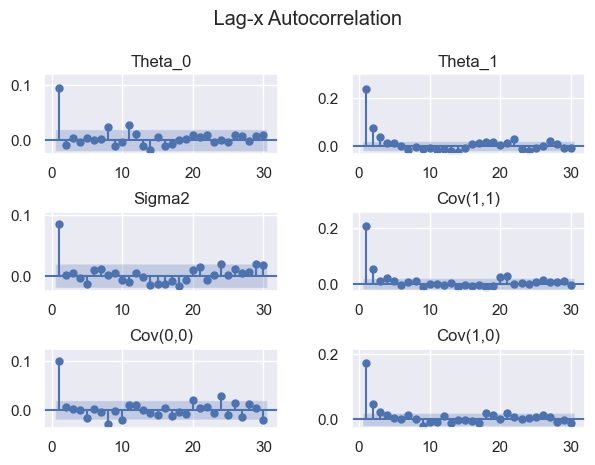

In [16]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.suptitle(" Lag-x Autocorrelation")
fig.tight_layout(pad=1.5)


ax1.set_title("Theta_0")
tsaplots.plot_acf(Theta[:,0], lags=30, zero=False, auto_ylims=True, ax=ax1, title="Theta_0")
ax2.set_title("Theta_1")
tsaplots.plot_acf(Theta[:,1], lags=30, zero=False, auto_ylims=True, ax=ax2, title="Theta_1")
ax3.set_title("Sigma2")
tsaplots.plot_acf(Sigma2, lags=30, zero=False, auto_ylims=True, ax=ax3, title="Sigma2")
ax4.set_title("Cov(1,1)")
tsaplots.plot_acf(Cov[:,1,1], lags=30, zero=False, auto_ylims=True, ax=ax4, title="Cov(1,1)")
ax5.set_title("Cov(0,0)")
tsaplots.plot_acf(Cov[:,0,0], lags=30, zero=False, auto_ylims=True, ax=ax5, title="Cov(0,0)")
ax6.set_title("Cov(1,0)")
tsaplots.plot_acf(Cov[:,1,0], lags=30, zero=False, auto_ylims=True, ax=ax6, title="Cov(1,0)")

plt.savefig("Unbiased Weak Prior Autocorrelation.png")
plt.show()

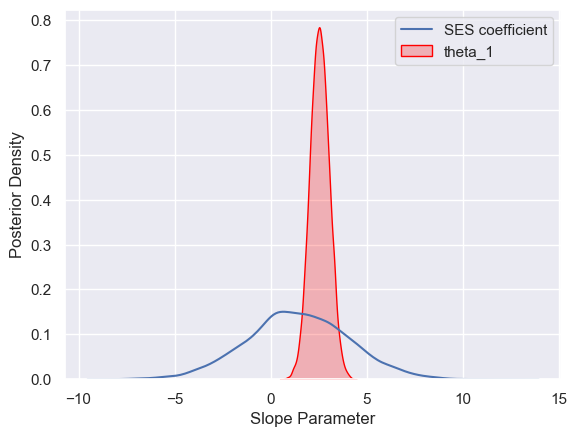

In [40]:
sns.set(style="darkgrid")
random_slope = Beta[:,5,:]
sns.kdeplot(random_slope[:,1], label="SES coefficient")
sns.kdeplot(Theta[:,1], label="theta_1", shade=True, color="red")
plt.ylabel('Posterior Density', fontsize=12)
plt.xlabel('Slope Parameter', fontsize=12)
plt.legend()
plt.show()

# Unbiased Uninformative Prior <a class="anchor" id="fourth-bullet"></a>
[Index](#index) <a class="anchor" id="index"></a>

In [20]:
#sigma2 prior parameters: inverse-gamma
V0 = 1
sigma2_0 = avg_within_group_sample_variance
#cov prior paramaters: inverse-Wishart
eta0 = 4
S0 = S0
#theta prior parameters: multivariate normal
mu0 = np.zeros(2)
tri_0 = average_theta_cov

Theta_r, Cov_r, Beta_r, Sigma2_r = posterior_independent_ses(data=df, mu0 = mu0, tri_0 = tri_0, eta0 = eta0, S0 = S0, V0 = V0, sigma2_0 = sigma2_0, burnin = 5000, iterafter_burnin = 10000)

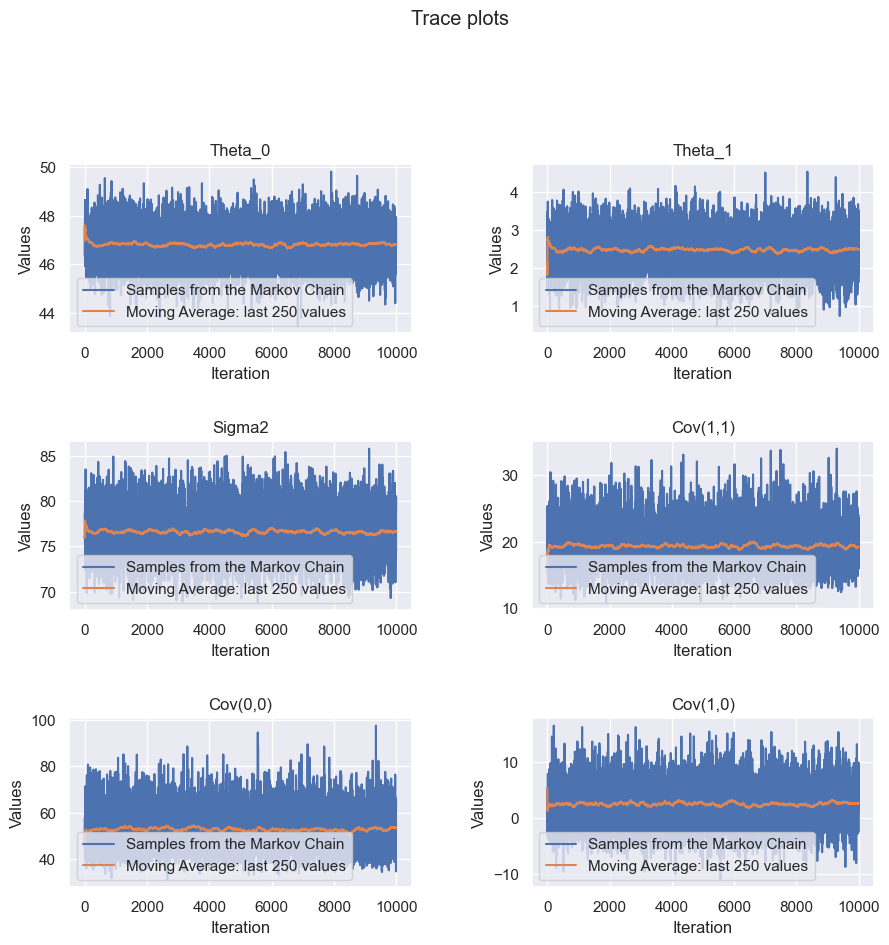

In [21]:
sns.set(style="darkgrid")

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (10,10))
fig.suptitle("Trace plots")
fig.tight_layout(pad=4.5)


ax1.set_title("Theta_0")
#ax1.plot(np.arange(5000), Theta_0_10th[:,0])
plot_trace(Theta_r[:,0], ax = ax1)
ax2.set_title("Theta_1")
#ax2.plot(np.arange(5000), Theta_0_10th[:,1])
plot_trace(Theta_r[:,1], ax = ax2)
ax3.set_title("Sigma2")
#ax3.plot(np.arange(5000), Sigma2_0_10th)
plot_trace(Sigma2_r, ax = ax3)
ax4.set_title("Cov(1,1)")
#ax4.plot(np.arange(5000), Cov_0_10th[:,1,1])
plot_trace(Cov_r[:,1,1], ax = ax4)
ax5.set_title("Cov(0,0)")
#ax5.plot(np.arange(5000), Cov_0_10th[:,0,0])
plot_trace(Cov_r[:,0,0], ax = ax5)
ax6.set_title("Cov(1,0)")
#ax6.plot(np.arange(5000), Cov_0_10th[:,1,0])
plot_trace(Cov_r[:,1,0], ax = ax6)

plt.savefig("Unbiased Uninformative Traceplots.png")
plt.show()

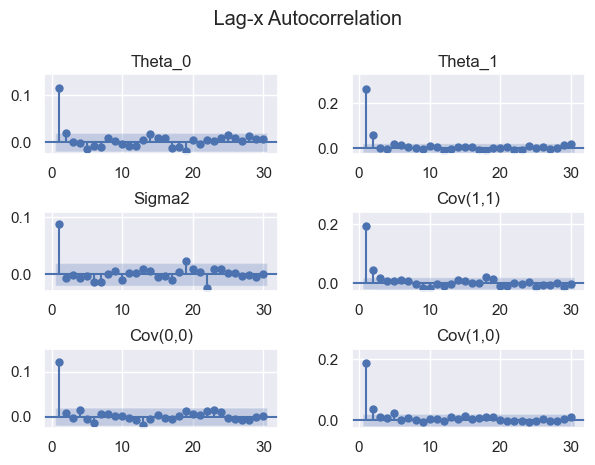

In [22]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.suptitle(" Lag-x Autocorrelation")
fig.tight_layout(pad=1.5)


ax1.set_title("Theta_0")
tsaplots.plot_acf(Theta_r[:,0], lags=30, zero=False, auto_ylims=True, ax=ax1, title="Theta_0")
ax2.set_title("Theta_1")
tsaplots.plot_acf(Theta_r[:,1], lags=30, zero=False, auto_ylims=True, ax=ax2, title="Theta_1")
ax3.set_title("Sigma2")
tsaplots.plot_acf(Sigma2_r, lags=30, zero=False, auto_ylims=True, ax=ax3, title="Sigma2")
ax4.set_title("Cov(1,1)")
tsaplots.plot_acf(Cov_r[:,1,1], lags=30, zero=False, auto_ylims=True, ax=ax4, title="Cov(1,1)")
ax5.set_title("Cov(0,0)")
tsaplots.plot_acf(Cov_r[:,0,0], lags=30, zero=False, auto_ylims=True, ax=ax5, title="Cov(0,0)")
ax6.set_title("Cov(1,0)")
tsaplots.plot_acf(Cov_r[:,1,0], lags=30, zero=False, auto_ylims=True, ax=ax6, title="Cov(1,0)")

plt.savefig("Unbiased Uninformative Autocorrelations.png")
plt.show()

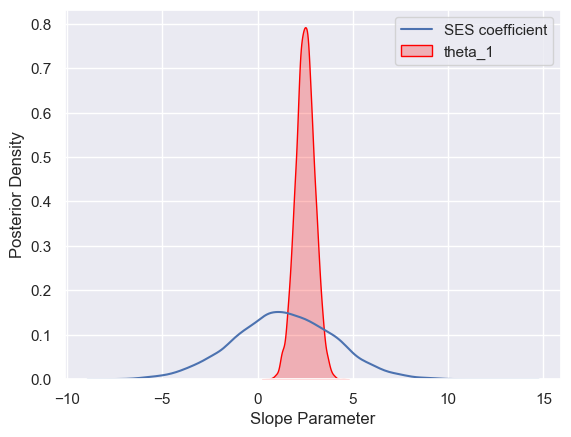

In [39]:
sns.set(style="darkgrid")
random_slope_r = Beta_r[:,5,:]
sns.kdeplot(random_slope_r[:,1], label="SES coefficient")
sns.kdeplot(Theta_r[:,1], label="theta_1", shade=True, color="red")
plt.ylabel('Posterior Density', fontsize=12)
plt.xlabel('Slope Parameter', fontsize=12)
plt.legend()
plt.show()

# Unbiased Informative Prior  <a class="anchor" id="fifth-bullet"></a>
[Index](#index) <a class="anchor" id="index"></a>

In [28]:
#sigma2 prior parameters: inverse-gamma
V0 = 1
sigma2_0 = avg_within_group_sample_variance
#cov prior paramaters: inverse-Wishart
eta0 = 25
S0 = S0
#theta prior parameters: multivariate normal
mu0 = np.array([48,2.7])
tri_0 = average_theta_cov

Theta_i, Cov_i, Beta_i, Sigma2_i = posterior_independent_ses(data=df, mu0 = mu0, tri_0 = tri_0, eta0 = eta0, S0 = S0, V0 = V0, sigma2_0 = sigma2_0, burnin = 5000, iterafter_burnin = 10000)

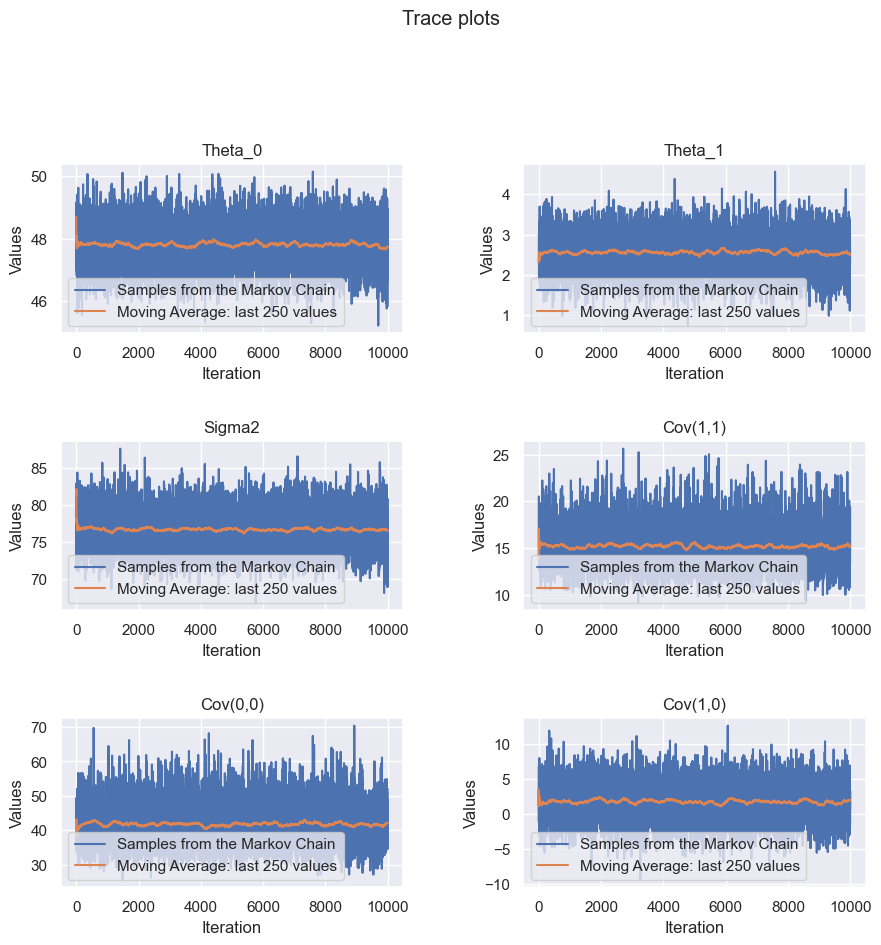

In [30]:
sns.set(style="darkgrid")

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (10,10))
fig.suptitle("Trace plots")
fig.tight_layout(pad=4.5)


ax1.set_title("Theta_0")
#ax1.plot(np.arange(5000), Theta_0_10th[:,0])
plot_trace(Theta_i[:,0], ax = ax1)
ax2.set_title("Theta_1")
#ax2.plot(np.arange(5000), Theta_0_10th[:,1])
plot_trace(Theta_i[:,1], ax = ax2)
ax3.set_title("Sigma2")
#ax3.plot(np.arange(5000), Sigma2_0_10th)
plot_trace(Sigma2_i, ax = ax3)
ax4.set_title("Cov(1,1)")
#ax4.plot(np.arange(5000), Cov_0_10th[:,1,1])
plot_trace(Cov_i[:,1,1], ax = ax4)
ax5.set_title("Cov(0,0)")
#ax5.plot(np.arange(5000), Cov_0_10th[:,0,0])
plot_trace(Cov_i[:,0,0], ax = ax5)
ax6.set_title("Cov(1,0)")
#ax6.plot(np.arange(5000), Cov_0_10th[:,1,0])
plot_trace(Cov_i[:,1,0], ax = ax6)

plt.savefig("Unbiased Informative Traceplots.png")
plt.show()

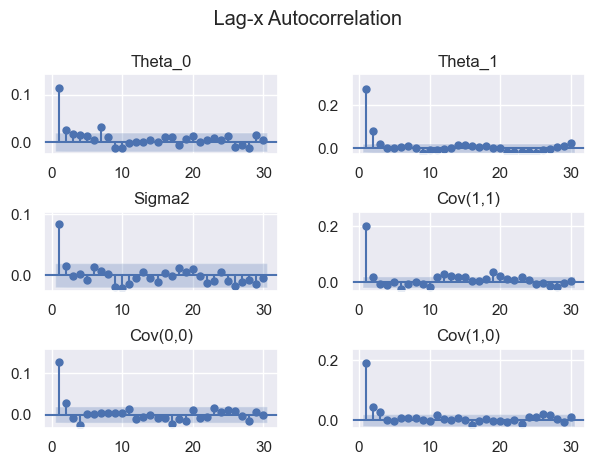

In [31]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.suptitle(" Lag-x Autocorrelation")
fig.tight_layout(pad=1.5)


ax1.set_title("Theta_0")
tsaplots.plot_acf(Theta_i[:,0], lags=30, zero=False, auto_ylims=True, ax=ax1, title="Theta_0")
ax2.set_title("Theta_1")
tsaplots.plot_acf(Theta_i[:,1], lags=30, zero=False, auto_ylims=True, ax=ax2, title="Theta_1")
ax3.set_title("Sigma2")
tsaplots.plot_acf(Sigma2_i, lags=30, zero=False, auto_ylims=True, ax=ax3, title="Sigma2")
ax4.set_title("Cov(1,1)")
tsaplots.plot_acf(Cov_i[:,1,1], lags=30, zero=False, auto_ylims=True, ax=ax4, title="Cov(1,1)")
ax5.set_title("Cov(0,0)")
tsaplots.plot_acf(Cov_i[:,0,0], lags=30, zero=False, auto_ylims=True, ax=ax5, title="Cov(0,0)")
ax6.set_title("Cov(1,0)")
tsaplots.plot_acf(Cov_i[:,1,0], lags=30, zero=False, auto_ylims=True, ax=ax6, title="Cov(1,0)")

plt.savefig("Unbiased Informative Autocorrelations.png")
plt.show()

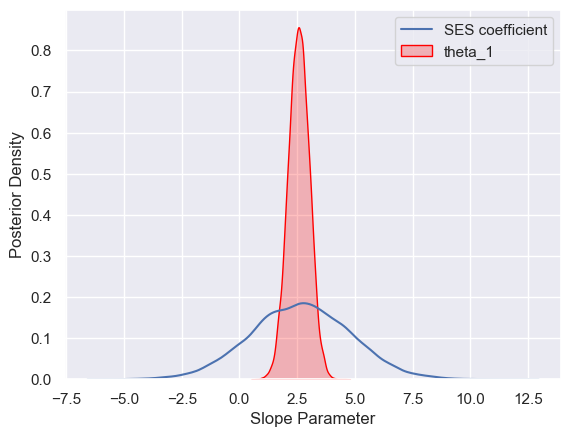

In [47]:
sns.set(style="darkgrid")
random_slope_i = Beta_i[:,6,:]
sns.kdeplot(random_slope_i[:,1], label="SES coefficient")
sns.kdeplot(Theta_i[:,1], label="theta_1", shade=True, color="red")
plt.ylabel('Posterior Density', fontsize=12)
plt.xlabel('Slope Parameter', fontsize=12)
plt.legend()
plt.savefig("Example")
plt.show()

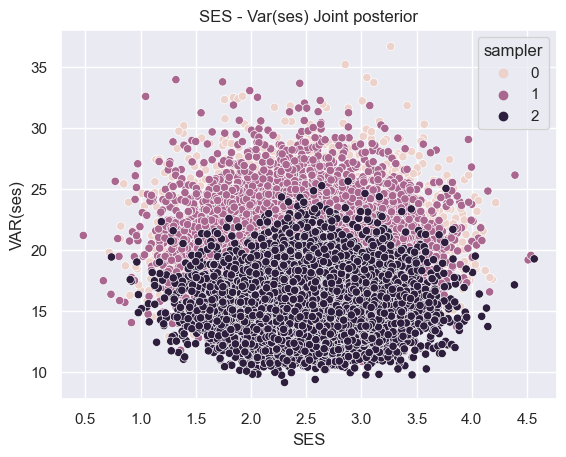

In [42]:
ses_samples = []
ses_samples.append(Theta[:,1])
ses_samples.append(Theta_r[:,1])
ses_samples.append(Theta_i[:,1])
cov_11 = []
cov_11.append(Cov[:,1,1])
cov_11.append(Cov_r[:,1,1])
cov_11.append(Cov_i[:,1,1])




ses_samples_df = pd.DataFrame(ses_samples).T.melt(var_name="sampler", value_name="SES")
cov_11_df = pd.DataFrame(cov_11).T.melt(var_name="sampler", value_name="VAR(ses)")
joint_samples_df = ses_samples_df.join(cov_11_df.drop(columns="sampler"))

plt.title("SES - Var(ses) Joint posterior")
sns.scatterplot(data=joint_samples_df, x="SES", y="VAR(ses)", hue="sampler")
plt.savefig("SES - Var(ses) Joint posterior.png")
plt.show()

In [43]:
X_mle = np.array(df['stu_ses'])
Y_mle = np.array(df['stu_mathscore'])
reg = LinearRegression().fit(X_mle.reshape(-1,1), Y_mle)
mle_ses = reg.coef_

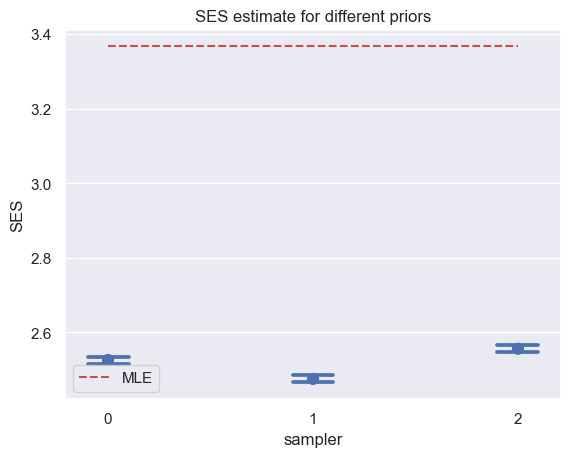

In [44]:
ses_samples = []
ses_samples.append(Theta[:,1])
ses_samples.append(Theta_r[:,1])
ses_samples.append(Theta_i[:,1])
ses_samples_df = pd.DataFrame(ses_samples).T.melt(var_name="sampler", value_name="SES")

plt.title("SES estimate for different priors")
sns.pointplot(data=ses_samples_df, x="sampler", y="SES", errorbar=("ci",95),
              capsize=.2, join=False)
plt.plot(np.arange(3), mle_ses * np.ones(3), "r--", label="MLE")
plt.legend(loc="lower left")

plt.savefig("Mu_different_priors.png")
plt.show()